# Figure 3

1. Compare hierarchy of different image embeddings

In [1]:
from utils import *
from plot_params import *
from scipy.stats import spearmanr, pearsonr
import dcor
from sklearn.manifold import MDS
from scikit_posthocs import posthoc_dunn
from sklearn.neighbors import KNeighborsClassifier

In [2]:
save = True
savepath = r'D:\Data\DeepMouse\Figures\Figure3'

## 1. Construct hierarchies of different embeddings and compare against representational hierarchy

In [3]:
# Plotting functions
def convert_cm2mat(conf_matrix):
    '''Convert a confusion matrix (nrepeats, region, region) to distance/similarity matrix by averaging across diagonal'''
    similarity = np.array([(X + X.T)/2 for X in conf_matrix])
    return similarity


def plot_matrix(data, regions, title='', figsize=(6,5)):
    '''Given confusion matrix (nrepeats, region, region), plot as matrix'''
    data_m = np.mean(data, axis=0)
    data_s = data.std(axis=0)
    mask = np.tri(data_m.shape[0], k=-1).T
    data_masked = np.ma.array(data_m, mask=mask)
    np.fill_diagonal(data_masked, data_m[np.triu_indices_from(data_m, k=1)].max())
    data_diff = (data_m-data_m.min())/(data_m.max()-data_m.min())

    fig, ax = pl.subplots(figsize=figsize)
    ax.imshow(data_masked, cmap='gray_r', vmin=data_m.min(), vmax=data_m.max())
    # ax.imshow(data_masked, cmap='gray_r', vmin=0, vmax=1)

    for i in range(len(regions)):
        for j in range(len(regions)):
            if i == j: continue
            if data_masked.mask[i,j]: continue
            if data_diff[i,j] < 0.5: color = [0]*3
            else: color = [1] * 3
            ax.text(j,i, f"{data_m[i,j]:.2f}\n±{data_s[i,j]:.0e}".replace("e-0", "e-"), ha='center', va='center', size=6, color=color)
    ax.set_xticks(range(data.shape[1]))
    ax.set_xticklabels(regions)
    #ax.xaxis.tick_top()
    ax.set_yticks(range(data.shape[1]))
    ax.set_yticklabels(regions)
    #ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # ax.set_title(title)

    return fig

def make_graph(data, regions, figsize=(6,5), theta=0, mirror=False, seed=0, title=''):
    '''Given matrix of similarities, construct a graph using MDS'''
    np.random.seed(seed)
    mds = MDS(dissimilarity='precomputed')
    sim = data.mean(axis=0)
    np.fill_diagonal(sim, np.nan)
    #dist = 1/sim
    sim = (sim-np.nanmin(sim))/(0.3-np.nanmin(sim))
    dist = 1-sim
    np.fill_diagonal(dist, 0)

    graph = mds.fit_transform(dist)

    # Rotate/flip if specified
    graph = rotate(graph, theta)
    if mirror: graph[:,0] = graph[:,0] * -1

    fig, ax = pl.subplots(figsize=figsize)
    for i, region in enumerate(regions):
        ax.plot(graph[i,0], graph[i,1], marker='o', color=colors[i], ms=40, zorder=99)
        ax.text(graph[i,0], graph[i,1], region, weight='bold', ha='center', va='center', size=16, zorder=100)
    
    for i in range(len(regions)):
        for j in range(i,len(regions)):
            if i == j: continue
            x0 = graph[i]
            dx = np.array([graph[j,0]-graph[i,0], graph[j,1]-graph[i,1]])
            b = 0.0
            a = b/np.linalg.norm(dx)
            ax.plot([(x0+dx*a)[0], (x0+dx*(1-a))[0]], [(x0+dx*a)[1], (x0+dx*(1-a))[1]], lw=sim[i,j]*10+1, color=[np.max([1-sim[i,j]-0.1,0])]*3, zorder=int(sim[i,j]*10))

    dscale = np.abs((graph.max(axis=0)-graph.min(axis=0)))*0.1
    ax.set_xlim(graph[:,0].min()-dscale[0], graph[:,0].max()+dscale[0])
    ax.set_ylim(graph[:,1].min()-dscale[0], graph[:,1].max()+dscale[1])
    ax.axis('off')
    
    return fig

def rotate(data, theta):
    '''Given a matrix of points in 2D, rotate by theta degrees about the centroid'''
    theta = np.deg2rad(theta)
    centroid = data.mean(axis=0)
    data_centred = data-centroid
    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    data_rot = data @ rot
    return data_rot

def plot_correlation(correlations, labels, figsize=(6,5), color_list=None, plot_maxline=False):
    '''Plot the distribution of correlations for different embeddings'''
    fig, ax = pl.subplots(figsize=figsize)
    positions = np.arange(1, len(correlations)+1).astype(float)
    positions[3:] = positions[3:] + .25
    bp1 = ax.boxplot(correlations, showfliers=False, positions=positions, widths=0.5, 
                     patch_artist=True, medianprops=dict(color='k'))

    if color_list is not None:
        for patch, color in zip(bp1['boxes'], color_list):
            patch.set_facecolor(color)

    if plot_maxline:
        ax.axhline(np.max([np.median(x) for x in correlations]), ls='--', color=[.5]*3)

    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    ax.set_ylim(0.2,1)
    ax.set_yticks([0.2, 0.6, 1])
    # ax.set_ylabel("Correlation")
    fig.tight_layout()

    return fig

def plot_accuracy(accuracy, labels, figsize=(6,5), color_list=None):
    '''Plot the accuracy of kNN classifier'''
    accuracy_m = [x.mean() for x in accuracy]
    accuracy_s = [x.std() for x in accuracy]

    fig, ax = pl.subplots(figsize=figsize)
    bp1 = ax.bar(np.arange(1, len(accuracy)+1), accuracy_m, color=color_list)
    ax.errorbar(np.arange(1, len(accuracy)+1), accuracy_m, yerr=accuracy_s, ls='', marker='', capsize=2, color='k', lw=1)

    ax.set_xticks(np.arange(1, len(accuracy)+1))
    ax.set_xticklabels(labels)
    ax.set_ylim(0,.6)
    ax.set_yticks([0,0.2,0.4,0.6])
    # ax.set_ylabel("Accuracy")

    fig.tight_layout()

    return fig


In [4]:
# Load embeddings
embedding_labels = ['Pixel', 'FFT', 'SimCNE full', 'SimCNE scale', 'SimCNE rotation', 'SimCNE translation', 'SimCNE scale + rotation', 
                    'SimCNE scale + translation', 'SimCNE rotation + translation', 'SimCNE affine']

cm_pixel = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_pixel.npy')


cm_fft = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_FFT.npy')
cm_cnefull = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNEfull.npy')
cm_cnescale = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNEscale.npy')
cm_cnerotation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNErotation.npy')
cm_cnetranslation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNEtranslation.npy')
cm_cnescalerotation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNEscalerotation.npy')
cm_cnescaletranslation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNEscaletranslation.npy')
cm_cnerotationtranslation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNErotationtranslation.npy')
cm_cneaffine = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\confusion_matrix_SimCNEaffine.npy')

# Get the performance of the kNN (messy but can't be bothered)
k = 1
cms = [cm_pixel, cm_fft, cm_cnefull, cm_cnescale, cm_cnerotation, cm_cnetranslation, 
       cm_cnescalerotation, cm_cnescaletranslation, cm_cnerotationtranslation, cm_cneaffine]
sims = [convert_cm2mat(cm[k]) for cm in cms]
accuracies = np.array([np.array([np.diagonal(sim[i]).mean() for i in range(sim.shape[0])]) for sim in sims])

cm_pixel = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_pixel.npy')
cm_fft = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_FFT.npy')
cm_cnefull = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNEfull.npy')
cm_cnescale = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNEscale.npy')
cm_cnerotation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNErotation.npy')
cm_cnetranslation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNEtranslation.npy')
cm_cnescalerotation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNEscalerotation.npy')
cm_cnescaletranslation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNEscaletranslation.npy')
cm_cnerotationtranslation = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNErotationtranslation.npy')
cm_cneaffine = np.load(r'D:\Data\DeepMouse\Results\neuron_topology\probability_matrix_SimCNEaffine.npy')

cms = [cm_pixel, cm_fft, cm_cnefull, cm_cnescale, cm_cnerotation, cm_cnetranslation, 
       cm_cnescalerotation, cm_cnescaletranslation, cm_cnerotationtranslation, cm_cneaffine]
sims = [convert_cm2mat(cm[k]) for cm in cms]

# Load representational hierarchy
dcorr = np.load(r'D:\Data\DeepMouse\Results\representational_similarity\dcor_nneuron-200_nstim-1000.npy')
pdcorr = np.load(r'D:\Data\DeepMouse\Results\representational_similarity\pdcor_nneuron-200_nstim-1000.npy')

# Calculate correlation between embeddings and dcorr/pdcorr
dcor_correlation = np.array([[dcor.distance_correlation(dcorr[:,:,j][np.triu_indices(len(regions), k=1)], sims[i][j][np.triu_indices(len(regions), k=1)]
                            ) for i in range(len(sims))] for j in range(sims[0].shape[0])])

pdcor_correlation = np.array([[dcor.distance_correlation(pdcorr[:,:,j][np.triu_indices(len(regions), k=1)], sims[i][j][np.triu_indices(len(regions), k=1)]
                            ) for i in range(len(sims))] for j in range(sims[0].shape[0])])

dcor_correlation = np.array([[spearmanr(dcorr[:,:,j][np.triu_indices(len(regions), k=1)], sims[i][j][np.triu_indices(len(regions), k=1)]
                            )[0] for i in range(len(sims))] for j in range(sims[0].shape[0])])

pdcor_correlation = np.array([[spearmanr(pdcorr[:,:,j][np.triu_indices(len(regions), k=1)], sims[i][j][np.triu_indices(len(regions), k=1)]
                            )[0] for i in range(len(sims))] for j in range(sims[0].shape[0])])


              1             2             3
1  1.000000e+00  1.000000e+00  6.543938e-32
2  1.000000e+00  1.000000e+00  5.921717e-36
3  6.543938e-32  5.921717e-36  1.000000e+00


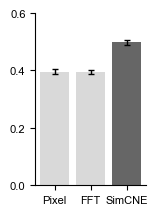

In [5]:
accuracy = [accuracies[0], accuracies[1], accuracies[-1]]
labels = [embedding_labels[0], embedding_labels[1], 'SimCNE']
color_list = [[.85]*3, [.85]*3, [.4]*3]
fig0 = plot_accuracy(accuracy, figsize=(1.6,2.2), labels=labels, color_list=color_list)
if save: fig0.savefig(os.path.join(savepath, 'accuracy.eps'))
print(posthoc_dunn(accuracy, p_adjust='bonferroni'))

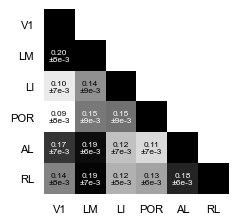

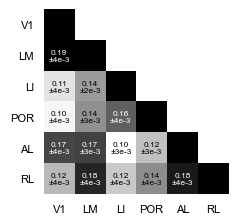

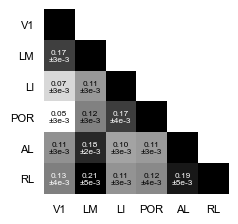

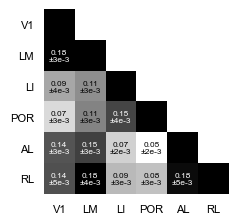

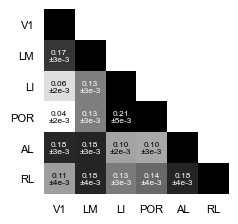

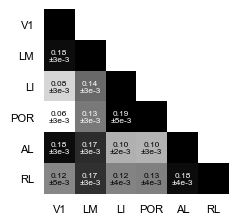

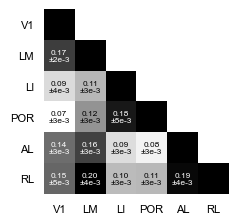

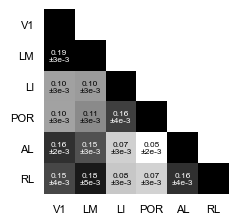

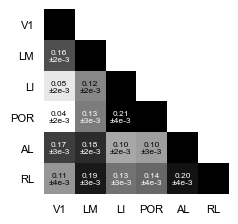

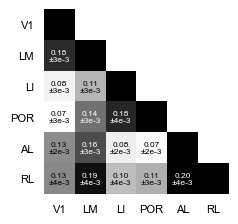

In [6]:
figs1 = [plot_matrix(sim, regions, title=embedding_labels[i], figsize=(2.4,2.4)) for i, sim in enumerate(sims)]
if save:
    for i, f in enumerate(figs1):
        f.savefig(os.path.join(savepath, f"similarity_matrix_{embedding_labels[i]}.pdf"), bbox_inches='tight')

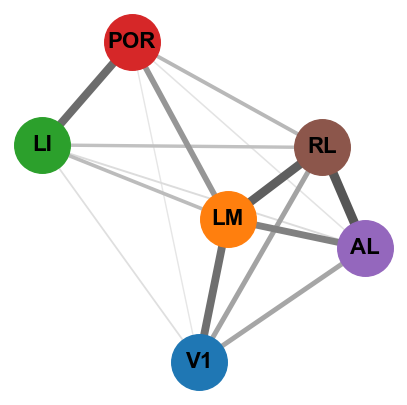

In [7]:
fig2 = make_graph(sims[-1], regions, figsize=(5,5), theta=130, mirror=True, seed=1, title='')
if save: fig2.savefig(os.path.join(savepath, 'graph_affine.pdf'))

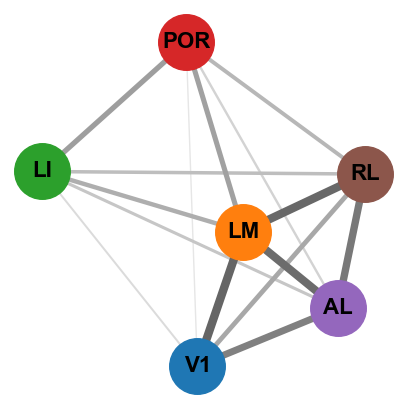

In [8]:
fig3 = make_graph(sims[0], regions, figsize=(5,5), theta=120, mirror=True, seed=1, title='')
if save: fig3.savefig(os.path.join(savepath, 'graph_pixel.pdf'))

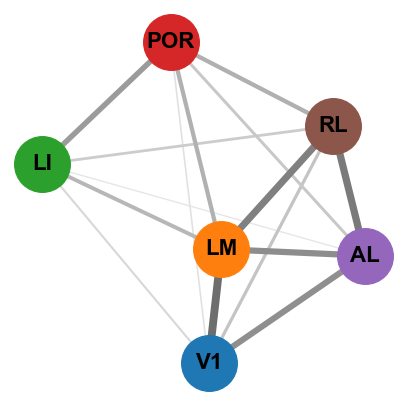

In [9]:
fig4 = make_graph(sims[1], regions, figsize=(5,5), theta=-170, mirror=True, seed=0, title='')
if save: fig4.savefig(os.path.join(savepath, 'graph_FFT.pdf'))

              1             2             3
1  1.000000e+00  1.000000e+00  1.353784e-20
2  1.000000e+00  1.000000e+00  9.298443e-24
3  1.353784e-20  9.298443e-24  1.000000e+00


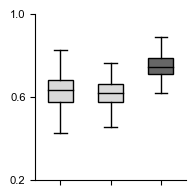

In [10]:
correlations = [pdcor_correlation[:,0], pdcor_correlation[:,1], pdcor_correlation[:,-1]]#, pdcor_correlation[:,-4], pdcor_correlation[:,-3], pdcor_correlation[:,-2]]
labels = [embedding_labels[0], embedding_labels[1], 'SimCNE\naffine']#, 'SimCNE\nno transl.', 'SimCNE\nno rot.', 'SimCNE\nno scale']
labels = ['']*len(correlations)
color_list = [[.85]*3, [.85]*3, [.4]*3]#, [.4]*3, [.4]*3, [.4]*3]
fig5 = plot_correlation(correlations, figsize=(2.,2), labels=labels, color_list=color_list)
if save: fig5.savefig(os.path.join(savepath, 'correlation_pdcor.eps'))
print(posthoc_dunn(correlations, p_adjust='bonferroni') )

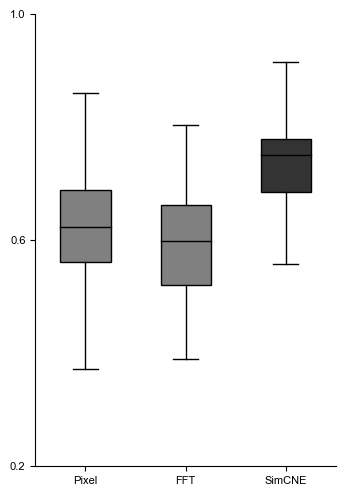

In [11]:
correlations = [dcor_correlation[:,0], dcor_correlation[:,1], dcor_correlation[:,-1]]
labels = [embedding_labels[0], embedding_labels[1], 'SimCNE']
color_list = [[.5]*3, [.5]*3, [.2]*3]
fig6 = plot_correlation(correlations, figsize=(3.5,5), labels=labels, color_list=color_list)
if save: fig6.savefig(os.path.join(savepath, 'correlation_pdcor.pdf'))

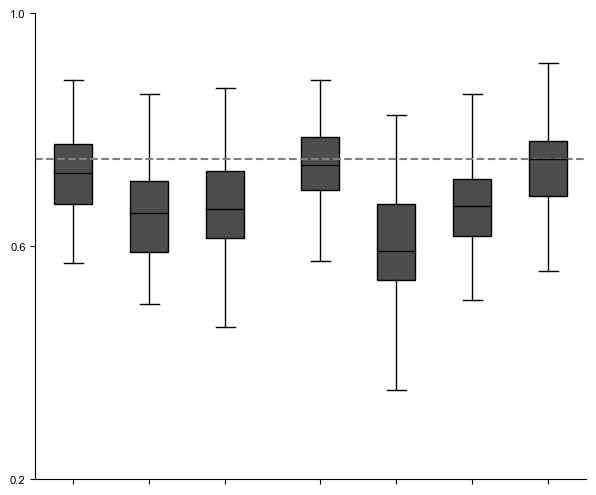

In [12]:
correlations = [dcor_correlation[:,i] for i in np.arange(3, dcor_correlation.shape[1])]
labels = ['' for i in np.arange(3, dcor_correlation.shape[1])]
color_list = [[.3]*3]*len(labels)
fig7 = plot_correlation(correlations, figsize=(6,5), labels=labels, color_list=color_list, plot_maxline=True)
if save: fig7.savefig(os.path.join(savepath, 'correlation_stratified.pdf'))

## 2. Visualise affine embedding

In [13]:
# Plot functions
def visualise_embedding(embedding, figsize=(6,5)):
    '''Visualise the umap embedding for each region separately'''
    all_data = np.concatenate([embedding[region] for region in regions], axis=0)
    fig, axes = pl.subplots(figsize=figsize, ncols=3, nrows=2)
    for i, ax in enumerate(axes.reshape(-1)):
        ax.plot(all_data[:,0], all_data[:,1], marker='.', ms=0.1, color='k', ls='')
        ax.plot(embedding[regions[i]][:,0], embedding[regions[i]][:,1], marker='.', ms=1, color=colors[i], ls='')

        ax.axis('off')
    
    return fig

def visualise_embedding_all(embedding, labels, figsize=(6,5)):
    '''Visualise the umap embedding all together'''
    fig, ax = pl.subplots(figsize=figsize)
    for i in np.unique(labels).astype(int):
        ax.plot(embedding[labels==i][:,0], embedding[labels==i][:,1], marker='.', ms=4, color=colors[i], ls='')
    
    ax.axis('off')
    
    return fig

In [14]:
fp_embed = r'D:\Data\DeepMouse\Results\neuron_topology\SimCNE_affine_embedding.npy'
fp_latents = r'D:\Data\DeepMouse\Results\neuron_topology\SimCNE_affine_latents.npy'
fp_opt = r'D:\Data\DeepMouse\Results\optstims\RF_aligned'
embedding = np.load(fp_embed, allow_pickle=True).item()
latents = np.load(fp_latents, allow_pickle=True).item()
masks = [np.load(os.path.join(fp_opt, f'good_optstim_{region}.npy')) for region in regions]

In [15]:
# Clean up embedding using KNN for better visualisation
labels = np.concatenate([np.zeros(latents[region].shape[0])+i for i, region in enumerate(regions)])
latents_flat = np.concatenate([latents[region] for region in regions])
embedding_flat = np.concatenate([embedding[region] for region in regions])

# Train KNN
kNN = KNeighborsClassifier(n_neighbors=50)
kNN.fit(latents_flat, labels)
labels_clean = kNN.predict(latents_flat)
print(pearsonr(labels, labels_clean))

(0.4951530921346421, 0.0)


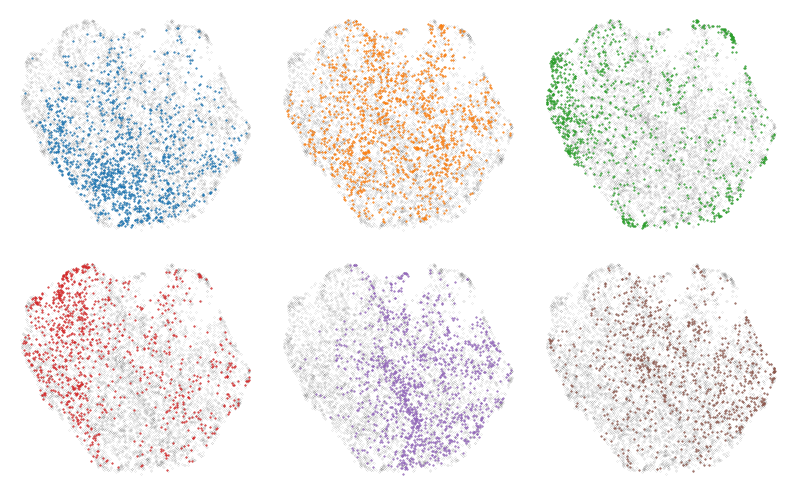

In [16]:
fig8 = visualise_embedding(embedding, figsize=(8,5))
fig8.tight_layout()
if save: fig8.savefig(os.path.join(savepath, 'embeddings_affine.pdf'))


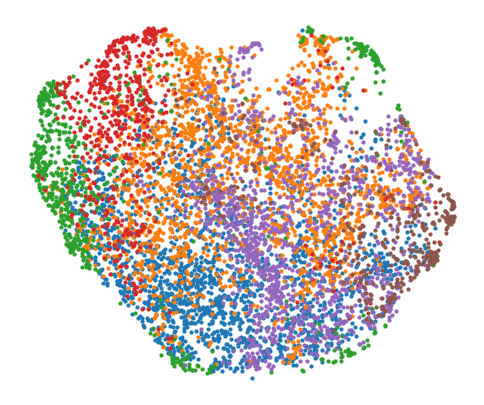

In [17]:
fig9 = visualise_embedding_all(embedding_flat, labels_clean)
if save: fig9.savefig(os.path.join(savepath, 'embeddings_affine_all.eps'))
